<a href="https://colab.research.google.com/github/inteliexec/Modulo3/blob/main/data-analytics/notebooks/Compare-Students-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/6 [00:00<?, ?it/s]

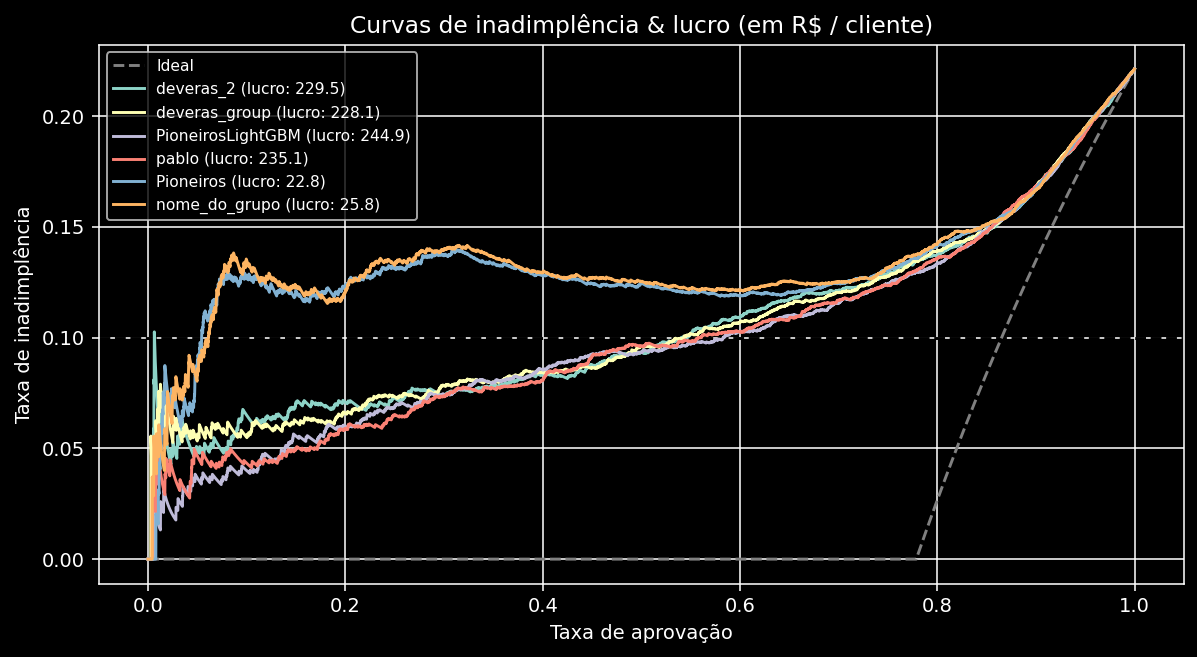

In [18]:
# @title Insira o nome da empresa {run: "auto"}
nome_empresa = "Outra" # @param ["BTG", "Ambev", "Outra"]

from google.colab import drive
drive.mount('/content/drive', force_remount=False, readonly=True)
!cp /content/drive/MyDrive/M3-Data/.env /content

import os
import shutil
local_path = f'/content/{nome_empresa}/'
if os.path.exists(local_path) and os.path.isdir(local_path):
  shutil.rmtree(local_path)
os.makedirs(local_path, exist_ok=True)

!pip install boto3 --quiet
!pip install python-dotenv --quiet

from dotenv import load_dotenv
load_dotenv()

import boto3

s3 = boto3.client('s3')
bucket_name = 'inteli-exec-bucket'
s3_path = f'{nome_empresa}/'

# Download all files from the specified S3 path
paginator = s3.get_paginator('list_objects_v2')
for page in paginator.paginate(Bucket=bucket_name, Prefix=s3_path):
    for obj in page.get('Contents', []):
        file_name = obj['Key'].split('/')[-1]
        s3.download_file(bucket_name, obj['Key'], os.path.join(local_path, file_name))

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rcParams['figure.dpi'] = 140
plt.style.use('dark_background')

folder = '/content/' + nome_empresa + '/'

target_delinq = 0.1
lucro_bom_pagador = 500
preju_mau_pagador = 300

files = []
for company_file in os.listdir(folder):
    if company_file.endswith('.xlsx'):
        files.append((company_file[:-5], company_file))

gabarito = pd.read_csv('/content/drive/MyDrive/M3-Data/InteliBank_Inadimplencia_de_credito__Gabarito.csv')
y_test = gabarito['default']

def build_curve(y_true, scores, burn=300):
    policy_df = pd.DataFrame({'score': scores, 'default': y_true}).sort_values('score', ascending=True).reset_index(drop=True)

    # construir taxa de inadimplência ao dividir a inadimplência total pelo total de indivíduos
    policy_df['taxa_inadimp'] = policy_df['default'].cumsum()/(policy_df.index + 1)
    policy_df['taxa_aprovacao'] = policy_df.index/len(policy_df)

    # remove the beginning of the curve
    aux = policy_df.iloc[burn:]
    best = aux.iloc[(aux['taxa_inadimp']-target_delinq).abs().argsort()].iloc[0]
    score = best.score
    taxa_aprov = best.taxa_aprovacao

    return policy_df, taxa_aprov


fig, ax = plt.subplots(figsize=(10,5))

plt.title(f"Curvas de inadimplência & lucro (em R$ / cliente)")
plt.xlabel("Taxa de aprovação")
plt.ylabel("Taxa de inadimplência")
plt.axhline(target_delinq, color='black', linestyle='--')
plt.grid()

ideal_df, _ = build_curve(y_test, y_test)
ax.plot(ideal_df['taxa_aprovacao'], ideal_df['taxa_inadimp'], label="Ideal", linestyle='--', color='gray')

for team, file in tqdm(files):
    scores = pd.read_excel(folder + file, usecols=['Prediction'])['Prediction']
    if len(scores) != len(y_test):
        print(f"{team} has length {len(scores)}")
        continue

    policy_df, taxa_aprov = build_curve(y_test, scores)
    lucro = lucro_bom_pagador * taxa_aprov * (1-target_delinq) - preju_mau_pagador * taxa_aprov * target_delinq

    ax.plot(policy_df['taxa_aprovacao'], policy_df['taxa_inadimp'], label=f"{team} (lucro: {lucro:.1f})")

plt.legend(prop={'size': 8})
plt.show()